In [2]:
#PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import numpy as np

#dataset
import torch.utils.data as utils

#For paths
import glob

#imread
from skimage import io, transform

#split dataset
from sklearn.model_selection import train_test_split

In [3]:
root_path = "D:/Downloads/kinect_leap_dataset/acquisitions"
p_id = ["P1", "P2", "P3", "P4", "P5", "P6", "P7", "P8", "P9", "P10", "P11", "P12", "P13", "P14"]
g_id = ["G1", "G2", "G3", "G4", "G5", "G6", "G7", "G8", "G9", "G10"]

In [4]:
print(root_path + "/P1/G1")
files = glob.glob(root_path + "/P1/G1/" + "*depth.png")
print(files)
print(len(files))

D:/Downloads/kinect_leap_dataset/acquisitions/P1/G1
['D:/Downloads/kinect_leap_dataset/acquisitions/P1/G1\\10_depth.png', 'D:/Downloads/kinect_leap_dataset/acquisitions/P1/G1\\1_depth.png', 'D:/Downloads/kinect_leap_dataset/acquisitions/P1/G1\\2_depth.png', 'D:/Downloads/kinect_leap_dataset/acquisitions/P1/G1\\3_depth.png', 'D:/Downloads/kinect_leap_dataset/acquisitions/P1/G1\\4_depth.png', 'D:/Downloads/kinect_leap_dataset/acquisitions/P1/G1\\5_depth.png', 'D:/Downloads/kinect_leap_dataset/acquisitions/P1/G1\\6_depth.png', 'D:/Downloads/kinect_leap_dataset/acquisitions/P1/G1\\7_depth.png', 'D:/Downloads/kinect_leap_dataset/acquisitions/P1/G1\\8_depth.png', 'D:/Downloads/kinect_leap_dataset/acquisitions/P1/G1\\9_depth.png']
10


In [5]:
dataset = []
labels = []

for p in p_id:
    for g in g_id:
        #print(p, g)
        image_names = glob.glob(root_path + "/" +  p + "/" + g + "/" + "*depth.png")
        for img_path in image_names:
            img = io.imread(img_path)
            img = transform.rescale(img, 1.0 / 4.0)
            
            img = np.resize(img,(1,120,160))
            
            dataset.append(img)
            
            #label 10 will be 0
            tmp = np.zeros(10)
            tmp[int(g[-1])] = 1
            labels.append(tmp)
            #labels.append(int(g[-1]))

C:\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [6]:
#ffs
dataset = np.array(dataset).astype(float)
labels = np.array(labels).astype(float)

In [7]:
print(type(labels))
print(type(dataset))
X_train, X_test_val, y_train, y_test_val = train_test_split(dataset, labels, test_size=0.2)
print(type(X_train))
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=0.5)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [8]:
dataset = torch.from_numpy(dataset).float()
labels = torch.from_numpy(labels).float()
print(type(dataset))
print(type(labels))

<class 'torch.FloatTensor'>
<class 'torch.FloatTensor'>


In [9]:
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()
X_val = torch.from_numpy(X_val).float()
y_val = torch.from_numpy(y_val).float()

In [10]:
my_dataset = utils.TensorDataset(dataset, labels) # create your dataset
my_dataloader = utils.DataLoader(my_dataset, batch_size=10, shuffle=True, num_workers=4) # create your dataloader

In [11]:
my_dataset = utils.TensorDataset(X_train, y_train) # create your dataset
train_loader = utils.DataLoader(my_dataset, batch_size=10, shuffle=True, num_workers=4) # create your dataloader

my_dataset = utils.TensorDataset(X_val, y_val) # create your dataset
val_loader = utils.DataLoader(my_dataset, batch_size=10, shuffle=True, num_workers=4) # create your dataloader

my_dataset = utils.TensorDataset(X_test, y_test) # create your dataset
test_loader = utils.DataLoader(my_dataset, batch_size=10, shuffle=True, num_workers=4) # create your dataloader

In [12]:
#input 640x480
#h=480, w=640
#downscaled by 4

#output 10 classes
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        #self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc1 = nn.Linear(16 * 37 * 27, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        #print(list(x.size()))
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, (2,2))
        #print(list(x.size()))
        
        #x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        #print(list(x.size()))
        x = x.view(-1, self.num_flat_features(x))
        
        #print(list(x.size()))
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [13]:
model = Net()
print(model)
#if torch.cuda.is_available():
#    net.cuda()

criterion = torch.nn.MSELoss(size_average=False)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

#criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.0)

Net(
  (conv1): Conv2d (1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d (6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=15984, out_features=120)
  (fc2): Linear(in_features=120, out_features=84)
  (fc3): Linear(in_features=84, out_features=10)
)


In [14]:
'''#my_dataset
#my_dataloader
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(my_dataloader, 0):
        # get the inputs
        inputs, labels = data
        inputs = Variable(inputs)
        inputs = inputs.float()
        labels = Variable(labels)
        labels = labels.float()
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')'''

"#my_dataset\n#my_dataloader\nfor epoch in range(2):  # loop over the dataset multiple times\n    running_loss = 0.0\n    for i, data in enumerate(my_dataloader, 0):\n        # get the inputs\n        inputs, labels = data\n        inputs = Variable(inputs)\n        inputs = inputs.float()\n        labels = Variable(labels)\n        labels = labels.float()\n        \n        # zero the parameter gradients\n        optimizer.zero_grad()\n\n        # forward + backward + optimize\n        outputs = net(inputs)\n        loss = criterion(outputs, labels)\n        loss.backward()\n        optimizer.step()\n\n        # print statistics\n        running_loss += loss.item()\n        if i % 2000 == 1999:    # print every 2000 mini-batches\n            print('[%d, %5d] loss: %.3f' %\n                  (epoch + 1, i + 1, running_loss / 2000))\n            running_loss = 0.0\n\nprint('Finished Training')"

In [15]:
#my_dataset
#my_dataloader

train_loss_history = []
train_acc_history = []
val_acc_history = []
val_loss_history = []
num_epochs = 500
iter_per_epoch = len(train_loader)
#224 lines -> 112 val output for log_nth=10000
#1120000 iter
log_nth = 16

if torch.cuda.is_available():
    model.cuda()

for epoch in range(num_epochs):  # loop over the dataset multiple times
    for i, (inputs, targets) in enumerate(train_loader, 1):
        inputs, targets = Variable(inputs.float()), Variable(targets.float())
        if torch.cuda.is_available():
            inputs, targets = inputs.cuda(), targets.cuda()
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # print statistics
        train_loss_history.append(loss.data.cpu().numpy())
        if log_nth and i % log_nth == 0:
            last_log_nth_losses = train_loss_history[-log_nth:]
            train_loss = np.mean(last_log_nth_losses)
            print('[Iteration %d/%d] TRAIN loss: %.3f' % \
                        (i + epoch * iter_per_epoch,
                         iter_per_epoch * num_epochs,
                         train_loss))
            
    _, preds = torch.max(outputs, 1)
    _, target_indices = torch.max(targets, 1)
    #print(preds)
    #print(targets)
    train_acc = np.mean((preds == target_indices).data.cpu().numpy())
    train_acc_history.append(train_acc)
    if log_nth:
        print('[Epoch %d/%d] TRAIN acc/loss: %.3f/%.3f' % (epoch + 1,
                                                            num_epochs,
                                                            train_acc,
                                                            loss))
        '''_, preds = torch.max(outputs, 1)

        # Only allow images/pixels with label >= 0 e.g. for segmentation
        targets_mask = labels >= 0
        train_acc = np.mean((preds == targets)[targets_mask].data.cpu().numpy())
        train_acc_history.append(train_acc)
        if log_nth:
            print('[Epoch %d/%d] TRAIN acc/loss: %.3f/%.3f' % (epoch + 1,
                                                                   num_epochs,
                                                                   train_acc,
                                                                   train_loss))'''
        
    # VALIDATION
    val_losses = []
    val_scores = []
    model.eval()
    for inputs, targets in val_loader:
        inputs, targets = Variable(inputs), Variable(targets)
        if torch.cuda.is_available():
            inputs, targets = inputs.cuda(), targets.cuda()

        outputs = model.forward(inputs)
        loss = criterion(outputs, targets)
        val_losses.append(loss.data.cpu().numpy())

        _, preds = torch.max(outputs, 1)
        _, target_indices = torch.max(targets, 1)

        scores = np.mean((preds == target_indices).data.cpu().numpy())
        val_scores.append(scores)

    model.train()
    val_acc, val_loss = np.mean(val_scores), np.mean(val_losses)
    val_acc_history.append(val_acc)
    val_loss_history.append(val_loss)
    if log_nth:
        print('[Epoch %d/%d] VAL   acc/loss: %.3f/%.3f' % (epoch + 1,
                                                            num_epochs,
                                                            val_acc,
                                                            val_loss))

print('Finished Training')

[Iteration 16/56000] TRAIN loss: 9.915
[Iteration 32/56000] TRAIN loss: 9.244
[Iteration 48/56000] TRAIN loss: 9.040
[Iteration 64/56000] TRAIN loss: 9.064
[Iteration 80/56000] TRAIN loss: 8.989
[Iteration 96/56000] TRAIN loss: 9.051
[Iteration 112/56000] TRAIN loss: 9.042
[Epoch 1/500] TRAIN acc/loss: 0.200/8.845
[Epoch 1/500] VAL   acc/loss: 0.079/9.052
[Iteration 128/56000] TRAIN loss: 8.984
[Iteration 144/56000] TRAIN loss: 9.048
[Iteration 160/56000] TRAIN loss: 8.971
[Iteration 176/56000] TRAIN loss: 8.946
[Iteration 192/56000] TRAIN loss: 8.951
[Iteration 208/56000] TRAIN loss: 8.965
[Iteration 224/56000] TRAIN loss: 8.906
[Epoch 2/500] TRAIN acc/loss: 0.000/8.817
[Epoch 2/500] VAL   acc/loss: 0.157/8.902
[Iteration 240/56000] TRAIN loss: 8.813
[Iteration 256/56000] TRAIN loss: 8.763
[Iteration 272/56000] TRAIN loss: 8.819
[Iteration 288/56000] TRAIN loss: 8.746
[Iteration 304/56000] TRAIN loss: 8.691
[Iteration 320/56000] TRAIN loss: 8.658
[Iteration 336/56000] TRAIN loss: 8.60

[Iteration 2496/56000] TRAIN loss: 2.348
[Iteration 2512/56000] TRAIN loss: 2.525
[Iteration 2528/56000] TRAIN loss: 2.415
[Iteration 2544/56000] TRAIN loss: 2.551
[Iteration 2560/56000] TRAIN loss: 2.617
[Iteration 2576/56000] TRAIN loss: 2.399
[Epoch 23/500] TRAIN acc/loss: 1.000/2.420
[Epoch 23/500] VAL   acc/loss: 0.779/4.256
[Iteration 2592/56000] TRAIN loss: 2.234
[Iteration 2608/56000] TRAIN loss: 2.193
[Iteration 2624/56000] TRAIN loss: 2.122
[Iteration 2640/56000] TRAIN loss: 2.274
[Iteration 2656/56000] TRAIN loss: 2.388
[Iteration 2672/56000] TRAIN loss: 2.278
[Iteration 2688/56000] TRAIN loss: 2.398
[Epoch 24/500] TRAIN acc/loss: 1.000/2.443
[Epoch 24/500] VAL   acc/loss: 0.807/4.255
[Iteration 2704/56000] TRAIN loss: 2.078
[Iteration 2720/56000] TRAIN loss: 2.030
[Iteration 2736/56000] TRAIN loss: 2.209
[Iteration 2752/56000] TRAIN loss: 2.138
[Iteration 2768/56000] TRAIN loss: 2.063
[Iteration 2784/56000] TRAIN loss: 2.176
[Iteration 2800/56000] TRAIN loss: 2.181
[Epoch 2

[Iteration 4976/56000] TRAIN loss: 0.445
[Iteration 4992/56000] TRAIN loss: 0.490
[Iteration 5008/56000] TRAIN loss: 0.424
[Iteration 5024/56000] TRAIN loss: 0.413
[Iteration 5040/56000] TRAIN loss: 0.445
[Epoch 45/500] TRAIN acc/loss: 1.000/0.415
[Epoch 45/500] VAL   acc/loss: 0.850/3.189
[Iteration 5056/56000] TRAIN loss: 0.401
[Iteration 5072/56000] TRAIN loss: 0.331
[Iteration 5088/56000] TRAIN loss: 0.436
[Iteration 5104/56000] TRAIN loss: 0.472
[Iteration 5120/56000] TRAIN loss: 0.420
[Iteration 5136/56000] TRAIN loss: 0.432
[Iteration 5152/56000] TRAIN loss: 0.417
[Epoch 46/500] TRAIN acc/loss: 1.000/0.427
[Epoch 46/500] VAL   acc/loss: 0.843/3.124
[Iteration 5168/56000] TRAIN loss: 0.399
[Iteration 5184/56000] TRAIN loss: 0.388
[Iteration 5200/56000] TRAIN loss: 0.375
[Iteration 5216/56000] TRAIN loss: 0.410
[Iteration 5232/56000] TRAIN loss: 0.438
[Iteration 5248/56000] TRAIN loss: 0.353
[Iteration 5264/56000] TRAIN loss: 0.359
[Epoch 47/500] TRAIN acc/loss: 1.000/0.308
[Epoch

[Iteration 7440/56000] TRAIN loss: 0.113
[Iteration 7456/56000] TRAIN loss: 0.107
[Iteration 7472/56000] TRAIN loss: 0.111
[Iteration 7488/56000] TRAIN loss: 0.093
[Iteration 7504/56000] TRAIN loss: 0.092
[Epoch 67/500] TRAIN acc/loss: 1.000/0.083
[Epoch 67/500] VAL   acc/loss: 0.864/2.768
[Iteration 7520/56000] TRAIN loss: 0.095
[Iteration 7536/56000] TRAIN loss: 0.100
[Iteration 7552/56000] TRAIN loss: 0.102
[Iteration 7568/56000] TRAIN loss: 0.103
[Iteration 7584/56000] TRAIN loss: 0.092
[Iteration 7600/56000] TRAIN loss: 0.103
[Iteration 7616/56000] TRAIN loss: 0.105
[Epoch 68/500] TRAIN acc/loss: 1.000/0.090
[Epoch 68/500] VAL   acc/loss: 0.864/2.768
[Iteration 7632/56000] TRAIN loss: 0.097
[Iteration 7648/56000] TRAIN loss: 0.109
[Iteration 7664/56000] TRAIN loss: 0.092
[Iteration 7680/56000] TRAIN loss: 0.097
[Iteration 7696/56000] TRAIN loss: 0.094
[Iteration 7712/56000] TRAIN loss: 0.107
[Iteration 7728/56000] TRAIN loss: 0.093
[Epoch 69/500] TRAIN acc/loss: 1.000/0.164
[Epoch

[Iteration 9904/56000] TRAIN loss: 0.042
[Iteration 9920/56000] TRAIN loss: 0.040
[Iteration 9936/56000] TRAIN loss: 0.047
[Iteration 9952/56000] TRAIN loss: 0.046
[Iteration 9968/56000] TRAIN loss: 0.059
[Epoch 89/500] TRAIN acc/loss: 1.000/0.069
[Epoch 89/500] VAL   acc/loss: 0.864/2.603
[Iteration 9984/56000] TRAIN loss: 0.046
[Iteration 10000/56000] TRAIN loss: 0.049
[Iteration 10016/56000] TRAIN loss: 0.055
[Iteration 10032/56000] TRAIN loss: 0.044
[Iteration 10048/56000] TRAIN loss: 0.040
[Iteration 10064/56000] TRAIN loss: 0.045
[Iteration 10080/56000] TRAIN loss: 0.041
[Epoch 90/500] TRAIN acc/loss: 1.000/0.039
[Epoch 90/500] VAL   acc/loss: 0.864/2.657
[Iteration 10096/56000] TRAIN loss: 0.047
[Iteration 10112/56000] TRAIN loss: 0.046
[Iteration 10128/56000] TRAIN loss: 0.041
[Iteration 10144/56000] TRAIN loss: 0.038
[Iteration 10160/56000] TRAIN loss: 0.045
[Iteration 10176/56000] TRAIN loss: 0.048
[Iteration 10192/56000] TRAIN loss: 0.045
[Epoch 91/500] TRAIN acc/loss: 1.000

[Epoch 110/500] VAL   acc/loss: 0.857/2.579
[Iteration 12336/56000] TRAIN loss: 0.041
[Iteration 12352/56000] TRAIN loss: 0.036
[Iteration 12368/56000] TRAIN loss: 0.035
[Iteration 12384/56000] TRAIN loss: 0.045
[Iteration 12400/56000] TRAIN loss: 0.036
[Iteration 12416/56000] TRAIN loss: 0.041
[Iteration 12432/56000] TRAIN loss: 0.041
[Epoch 111/500] TRAIN acc/loss: 1.000/0.043
[Epoch 111/500] VAL   acc/loss: 0.871/2.583
[Iteration 12448/56000] TRAIN loss: 0.053
[Iteration 12464/56000] TRAIN loss: 0.048
[Iteration 12480/56000] TRAIN loss: 0.053
[Iteration 12496/56000] TRAIN loss: 0.051
[Iteration 12512/56000] TRAIN loss: 0.046
[Iteration 12528/56000] TRAIN loss: 0.043
[Iteration 12544/56000] TRAIN loss: 0.051
[Epoch 112/500] TRAIN acc/loss: 1.000/0.043
[Epoch 112/500] VAL   acc/loss: 0.871/2.564
[Iteration 12560/56000] TRAIN loss: 0.050
[Iteration 12576/56000] TRAIN loss: 0.046
[Iteration 12592/56000] TRAIN loss: 0.047
[Iteration 12608/56000] TRAIN loss: 0.045
[Iteration 12624/56000] 

[Iteration 14752/56000] TRAIN loss: 0.033
[Iteration 14768/56000] TRAIN loss: 0.032
[Iteration 14784/56000] TRAIN loss: 0.033
[Epoch 132/500] TRAIN acc/loss: 1.000/0.023
[Epoch 132/500] VAL   acc/loss: 0.857/2.522
[Iteration 14800/56000] TRAIN loss: 0.031
[Iteration 14816/56000] TRAIN loss: 0.030
[Iteration 14832/56000] TRAIN loss: 0.031
[Iteration 14848/56000] TRAIN loss: 0.024
[Iteration 14864/56000] TRAIN loss: 0.027
[Iteration 14880/56000] TRAIN loss: 0.025
[Iteration 14896/56000] TRAIN loss: 0.025
[Epoch 133/500] TRAIN acc/loss: 1.000/0.040
[Epoch 133/500] VAL   acc/loss: 0.871/2.471
[Iteration 14912/56000] TRAIN loss: 0.027
[Iteration 14928/56000] TRAIN loss: 0.026
[Iteration 14944/56000] TRAIN loss: 0.024
[Iteration 14960/56000] TRAIN loss: 0.020
[Iteration 14976/56000] TRAIN loss: 0.026
[Iteration 14992/56000] TRAIN loss: 0.023
[Iteration 15008/56000] TRAIN loss: 0.020
[Epoch 134/500] TRAIN acc/loss: 1.000/0.019
[Epoch 134/500] VAL   acc/loss: 0.857/2.536
[Iteration 15024/56000

[Iteration 17152/56000] TRAIN loss: 0.019
[Iteration 17168/56000] TRAIN loss: 0.017
[Iteration 17184/56000] TRAIN loss: 0.020
[Iteration 17200/56000] TRAIN loss: 0.019
[Iteration 17216/56000] TRAIN loss: 0.016
[Iteration 17232/56000] TRAIN loss: 0.017
[Iteration 17248/56000] TRAIN loss: 0.015
[Epoch 154/500] TRAIN acc/loss: 1.000/0.015
[Epoch 154/500] VAL   acc/loss: 0.850/2.479
[Iteration 17264/56000] TRAIN loss: 0.016
[Iteration 17280/56000] TRAIN loss: 0.014
[Iteration 17296/56000] TRAIN loss: 0.014
[Iteration 17312/56000] TRAIN loss: 0.014
[Iteration 17328/56000] TRAIN loss: 0.014
[Iteration 17344/56000] TRAIN loss: 0.017
[Iteration 17360/56000] TRAIN loss: 0.015
[Epoch 155/500] TRAIN acc/loss: 1.000/0.021
[Epoch 155/500] VAL   acc/loss: 0.864/2.491
[Iteration 17376/56000] TRAIN loss: 0.014
[Iteration 17392/56000] TRAIN loss: 0.014
[Iteration 17408/56000] TRAIN loss: 0.016
[Iteration 17424/56000] TRAIN loss: 0.015
[Iteration 17440/56000] TRAIN loss: 0.014
[Iteration 17456/56000] TR

[Iteration 19600/56000] TRAIN loss: 0.022
[Epoch 175/500] TRAIN acc/loss: 1.000/0.021
[Epoch 175/500] VAL   acc/loss: 0.857/2.495
[Iteration 19616/56000] TRAIN loss: 0.019
[Iteration 19632/56000] TRAIN loss: 0.022
[Iteration 19648/56000] TRAIN loss: 0.019
[Iteration 19664/56000] TRAIN loss: 0.020
[Iteration 19680/56000] TRAIN loss: 0.021
[Iteration 19696/56000] TRAIN loss: 0.022
[Iteration 19712/56000] TRAIN loss: 0.029
[Epoch 176/500] TRAIN acc/loss: 1.000/0.014
[Epoch 176/500] VAL   acc/loss: 0.864/2.461
[Iteration 19728/56000] TRAIN loss: 0.023
[Iteration 19744/56000] TRAIN loss: 0.023
[Iteration 19760/56000] TRAIN loss: 0.023
[Iteration 19776/56000] TRAIN loss: 0.025
[Iteration 19792/56000] TRAIN loss: 0.027
[Iteration 19808/56000] TRAIN loss: 0.026
[Iteration 19824/56000] TRAIN loss: 0.025
[Epoch 177/500] TRAIN acc/loss: 1.000/0.028
[Epoch 177/500] VAL   acc/loss: 0.871/2.535
[Iteration 19840/56000] TRAIN loss: 0.024
[Iteration 19856/56000] TRAIN loss: 0.026
[Iteration 19872/56000

[Iteration 22000/56000] TRAIN loss: 0.025
[Iteration 22016/56000] TRAIN loss: 0.021
[Iteration 22032/56000] TRAIN loss: 0.024
[Iteration 22048/56000] TRAIN loss: 0.019
[Iteration 22064/56000] TRAIN loss: 0.020
[Epoch 197/500] TRAIN acc/loss: 1.000/0.022
[Epoch 197/500] VAL   acc/loss: 0.857/2.404
[Iteration 22080/56000] TRAIN loss: 0.019
[Iteration 22096/56000] TRAIN loss: 0.016
[Iteration 22112/56000] TRAIN loss: 0.015
[Iteration 22128/56000] TRAIN loss: 0.020
[Iteration 22144/56000] TRAIN loss: 0.019
[Iteration 22160/56000] TRAIN loss: 0.012
[Iteration 22176/56000] TRAIN loss: 0.017
[Epoch 198/500] TRAIN acc/loss: 1.000/0.016
[Epoch 198/500] VAL   acc/loss: 0.857/2.403
[Iteration 22192/56000] TRAIN loss: 0.015
[Iteration 22208/56000] TRAIN loss: 0.015
[Iteration 22224/56000] TRAIN loss: 0.014
[Iteration 22240/56000] TRAIN loss: 0.012
[Iteration 22256/56000] TRAIN loss: 0.015
[Iteration 22272/56000] TRAIN loss: 0.014
[Iteration 22288/56000] TRAIN loss: 0.020
[Epoch 199/500] TRAIN acc/

[Epoch 218/500] VAL   acc/loss: 0.871/2.356
[Iteration 24432/56000] TRAIN loss: 0.011
[Iteration 24448/56000] TRAIN loss: 0.009
[Iteration 24464/56000] TRAIN loss: 0.015
[Iteration 24480/56000] TRAIN loss: 0.009
[Iteration 24496/56000] TRAIN loss: 0.012
[Iteration 24512/56000] TRAIN loss: 0.009
[Iteration 24528/56000] TRAIN loss: 0.008
[Epoch 219/500] TRAIN acc/loss: 1.000/0.005
[Epoch 219/500] VAL   acc/loss: 0.864/2.410
[Iteration 24544/56000] TRAIN loss: 0.011
[Iteration 24560/56000] TRAIN loss: 0.007
[Iteration 24576/56000] TRAIN loss: 0.007
[Iteration 24592/56000] TRAIN loss: 0.009
[Iteration 24608/56000] TRAIN loss: 0.009
[Iteration 24624/56000] TRAIN loss: 0.011
[Iteration 24640/56000] TRAIN loss: 0.011
[Epoch 220/500] TRAIN acc/loss: 1.000/0.015
[Epoch 220/500] VAL   acc/loss: 0.864/2.338
[Iteration 24656/56000] TRAIN loss: 0.008
[Iteration 24672/56000] TRAIN loss: 0.009
[Iteration 24688/56000] TRAIN loss: 0.010
[Iteration 24704/56000] TRAIN loss: 0.010
[Iteration 24720/56000] 

[Iteration 26848/56000] TRAIN loss: 0.016
[Iteration 26864/56000] TRAIN loss: 0.019
[Iteration 26880/56000] TRAIN loss: 0.016
[Epoch 240/500] TRAIN acc/loss: 1.000/0.015
[Epoch 240/500] VAL   acc/loss: 0.871/2.339
[Iteration 26896/56000] TRAIN loss: 0.020
[Iteration 26912/56000] TRAIN loss: 0.016
[Iteration 26928/56000] TRAIN loss: 0.014
[Iteration 26944/56000] TRAIN loss: 0.014
[Iteration 26960/56000] TRAIN loss: 0.013
[Iteration 26976/56000] TRAIN loss: 0.016
[Iteration 26992/56000] TRAIN loss: 0.017
[Epoch 241/500] TRAIN acc/loss: 1.000/0.017
[Epoch 241/500] VAL   acc/loss: 0.864/2.355
[Iteration 27008/56000] TRAIN loss: 0.018
[Iteration 27024/56000] TRAIN loss: 0.019
[Iteration 27040/56000] TRAIN loss: 0.019
[Iteration 27056/56000] TRAIN loss: 0.017
[Iteration 27072/56000] TRAIN loss: 0.017
[Iteration 27088/56000] TRAIN loss: 0.017
[Iteration 27104/56000] TRAIN loss: 0.013
[Epoch 242/500] TRAIN acc/loss: 1.000/0.007
[Epoch 242/500] VAL   acc/loss: 0.871/2.309
[Iteration 27120/56000

[Iteration 29248/56000] TRAIN loss: 0.009
[Iteration 29264/56000] TRAIN loss: 0.008
[Iteration 29280/56000] TRAIN loss: 0.009
[Iteration 29296/56000] TRAIN loss: 0.010
[Iteration 29312/56000] TRAIN loss: 0.012
[Iteration 29328/56000] TRAIN loss: 0.010
[Iteration 29344/56000] TRAIN loss: 0.009
[Epoch 262/500] TRAIN acc/loss: 1.000/0.005
[Epoch 262/500] VAL   acc/loss: 0.843/2.330
[Iteration 29360/56000] TRAIN loss: 0.009
[Iteration 29376/56000] TRAIN loss: 0.007
[Iteration 29392/56000] TRAIN loss: 0.008
[Iteration 29408/56000] TRAIN loss: 0.009
[Iteration 29424/56000] TRAIN loss: 0.007
[Iteration 29440/56000] TRAIN loss: 0.009
[Iteration 29456/56000] TRAIN loss: 0.009
[Epoch 263/500] TRAIN acc/loss: 1.000/0.006
[Epoch 263/500] VAL   acc/loss: 0.857/2.372
[Iteration 29472/56000] TRAIN loss: 0.009
[Iteration 29488/56000] TRAIN loss: 0.011
[Iteration 29504/56000] TRAIN loss: 0.007
[Iteration 29520/56000] TRAIN loss: 0.007
[Iteration 29536/56000] TRAIN loss: 0.007
[Iteration 29552/56000] TR

[Iteration 31696/56000] TRAIN loss: 0.018
[Epoch 283/500] TRAIN acc/loss: 1.000/0.021
[Epoch 283/500] VAL   acc/loss: 0.871/2.342
[Iteration 31712/56000] TRAIN loss: 0.019
[Iteration 31728/56000] TRAIN loss: 0.019
[Iteration 31744/56000] TRAIN loss: 0.020
[Iteration 31760/56000] TRAIN loss: 0.018
[Iteration 31776/56000] TRAIN loss: 0.017
[Iteration 31792/56000] TRAIN loss: 0.015
[Iteration 31808/56000] TRAIN loss: 0.013
[Epoch 284/500] TRAIN acc/loss: 1.000/0.013
[Epoch 284/500] VAL   acc/loss: 0.857/2.384
[Iteration 31824/56000] TRAIN loss: 0.012
[Iteration 31840/56000] TRAIN loss: 0.013
[Iteration 31856/56000] TRAIN loss: 0.014
[Iteration 31872/56000] TRAIN loss: 0.014
[Iteration 31888/56000] TRAIN loss: 0.012
[Iteration 31904/56000] TRAIN loss: 0.012
[Iteration 31920/56000] TRAIN loss: 0.015
[Epoch 285/500] TRAIN acc/loss: 1.000/0.013
[Epoch 285/500] VAL   acc/loss: 0.850/2.342
[Iteration 31936/56000] TRAIN loss: 0.012
[Iteration 31952/56000] TRAIN loss: 0.011
[Iteration 31968/56000

[Iteration 34096/56000] TRAIN loss: 0.008
[Iteration 34112/56000] TRAIN loss: 0.008
[Iteration 34128/56000] TRAIN loss: 0.011
[Iteration 34144/56000] TRAIN loss: 0.010
[Iteration 34160/56000] TRAIN loss: 0.010
[Epoch 305/500] TRAIN acc/loss: 1.000/0.012
[Epoch 305/500] VAL   acc/loss: 0.871/2.295
[Iteration 34176/56000] TRAIN loss: 0.009
[Iteration 34192/56000] TRAIN loss: 0.013
[Iteration 34208/56000] TRAIN loss: 0.010
[Iteration 34224/56000] TRAIN loss: 0.008
[Iteration 34240/56000] TRAIN loss: 0.009
[Iteration 34256/56000] TRAIN loss: 0.008
[Iteration 34272/56000] TRAIN loss: 0.007
[Epoch 306/500] TRAIN acc/loss: 1.000/0.005
[Epoch 306/500] VAL   acc/loss: 0.857/2.316
[Iteration 34288/56000] TRAIN loss: 0.010
[Iteration 34304/56000] TRAIN loss: 0.007
[Iteration 34320/56000] TRAIN loss: 0.009
[Iteration 34336/56000] TRAIN loss: 0.007
[Iteration 34352/56000] TRAIN loss: 0.008
[Iteration 34368/56000] TRAIN loss: 0.008
[Iteration 34384/56000] TRAIN loss: 0.007
[Epoch 307/500] TRAIN acc/

[Epoch 326/500] VAL   acc/loss: 0.864/2.304
[Iteration 36528/56000] TRAIN loss: 0.013
[Iteration 36544/56000] TRAIN loss: 0.012
[Iteration 36560/56000] TRAIN loss: 0.013
[Iteration 36576/56000] TRAIN loss: 0.013
[Iteration 36592/56000] TRAIN loss: 0.010
[Iteration 36608/56000] TRAIN loss: 0.012
[Iteration 36624/56000] TRAIN loss: 0.014
[Epoch 327/500] TRAIN acc/loss: 1.000/0.010
[Epoch 327/500] VAL   acc/loss: 0.857/2.281
[Iteration 36640/56000] TRAIN loss: 0.012
[Iteration 36656/56000] TRAIN loss: 0.014
[Iteration 36672/56000] TRAIN loss: 0.016
[Iteration 36688/56000] TRAIN loss: 0.017
[Iteration 36704/56000] TRAIN loss: 0.019
[Iteration 36720/56000] TRAIN loss: 0.015
[Iteration 36736/56000] TRAIN loss: 0.012
[Epoch 328/500] TRAIN acc/loss: 1.000/0.008
[Epoch 328/500] VAL   acc/loss: 0.864/2.271
[Iteration 36752/56000] TRAIN loss: 0.010
[Iteration 36768/56000] TRAIN loss: 0.011
[Iteration 36784/56000] TRAIN loss: 0.008
[Iteration 36800/56000] TRAIN loss: 0.007
[Iteration 36816/56000] 

[Iteration 38944/56000] TRAIN loss: 0.005
[Iteration 38960/56000] TRAIN loss: 0.005
[Iteration 38976/56000] TRAIN loss: 0.006
[Epoch 348/500] TRAIN acc/loss: 1.000/0.005
[Epoch 348/500] VAL   acc/loss: 0.864/2.288
[Iteration 38992/56000] TRAIN loss: 0.006
[Iteration 39008/56000] TRAIN loss: 0.006
[Iteration 39024/56000] TRAIN loss: 0.007
[Iteration 39040/56000] TRAIN loss: 0.007
[Iteration 39056/56000] TRAIN loss: 0.005
[Iteration 39072/56000] TRAIN loss: 0.006
[Iteration 39088/56000] TRAIN loss: 0.006
[Epoch 349/500] TRAIN acc/loss: 1.000/0.005
[Epoch 349/500] VAL   acc/loss: 0.864/2.250
[Iteration 39104/56000] TRAIN loss: 0.006
[Iteration 39120/56000] TRAIN loss: 0.006
[Iteration 39136/56000] TRAIN loss: 0.006
[Iteration 39152/56000] TRAIN loss: 0.005
[Iteration 39168/56000] TRAIN loss: 0.006
[Iteration 39184/56000] TRAIN loss: 0.006
[Iteration 39200/56000] TRAIN loss: 0.008
[Epoch 350/500] TRAIN acc/loss: 1.000/0.005
[Epoch 350/500] VAL   acc/loss: 0.864/2.251
[Iteration 39216/56000

[Iteration 41344/56000] TRAIN loss: 0.007
[Iteration 41360/56000] TRAIN loss: 0.007
[Iteration 41376/56000] TRAIN loss: 0.009
[Iteration 41392/56000] TRAIN loss: 0.009
[Iteration 41408/56000] TRAIN loss: 0.009
[Iteration 41424/56000] TRAIN loss: 0.007
[Iteration 41440/56000] TRAIN loss: 0.007
[Epoch 370/500] TRAIN acc/loss: 1.000/0.006
[Epoch 370/500] VAL   acc/loss: 0.864/2.279
[Iteration 41456/56000] TRAIN loss: 0.006
[Iteration 41472/56000] TRAIN loss: 0.006
[Iteration 41488/56000] TRAIN loss: 0.007
[Iteration 41504/56000] TRAIN loss: 0.007
[Iteration 41520/56000] TRAIN loss: 0.006
[Iteration 41536/56000] TRAIN loss: 0.008
[Iteration 41552/56000] TRAIN loss: 0.008
[Epoch 371/500] TRAIN acc/loss: 1.000/0.007
[Epoch 371/500] VAL   acc/loss: 0.871/2.217
[Iteration 41568/56000] TRAIN loss: 0.007
[Iteration 41584/56000] TRAIN loss: 0.007
[Iteration 41600/56000] TRAIN loss: 0.007
[Iteration 41616/56000] TRAIN loss: 0.006
[Iteration 41632/56000] TRAIN loss: 0.007
[Iteration 41648/56000] TR

[Iteration 43792/56000] TRAIN loss: 0.006
[Epoch 391/500] TRAIN acc/loss: 1.000/0.005
[Epoch 391/500] VAL   acc/loss: 0.886/2.258
[Iteration 43808/56000] TRAIN loss: 0.006
[Iteration 43824/56000] TRAIN loss: 0.006
[Iteration 43840/56000] TRAIN loss: 0.008
[Iteration 43856/56000] TRAIN loss: 0.009
[Iteration 43872/56000] TRAIN loss: 0.006
[Iteration 43888/56000] TRAIN loss: 0.007
[Iteration 43904/56000] TRAIN loss: 0.007
[Epoch 392/500] TRAIN acc/loss: 1.000/0.008
[Epoch 392/500] VAL   acc/loss: 0.871/2.270
[Iteration 43920/56000] TRAIN loss: 0.008
[Iteration 43936/56000] TRAIN loss: 0.008
[Iteration 43952/56000] TRAIN loss: 0.009
[Iteration 43968/56000] TRAIN loss: 0.008
[Iteration 43984/56000] TRAIN loss: 0.009
[Iteration 44000/56000] TRAIN loss: 0.010
[Iteration 44016/56000] TRAIN loss: 0.008
[Epoch 393/500] TRAIN acc/loss: 1.000/0.009
[Epoch 393/500] VAL   acc/loss: 0.864/2.213
[Iteration 44032/56000] TRAIN loss: 0.008
[Iteration 44048/56000] TRAIN loss: 0.009
[Iteration 44064/56000

[Iteration 46192/56000] TRAIN loss: 0.006
[Iteration 46208/56000] TRAIN loss: 0.005
[Iteration 46224/56000] TRAIN loss: 0.005
[Iteration 46240/56000] TRAIN loss: 0.005
[Iteration 46256/56000] TRAIN loss: 0.006
[Epoch 413/500] TRAIN acc/loss: 1.000/0.009
[Epoch 413/500] VAL   acc/loss: 0.871/2.243
[Iteration 46272/56000] TRAIN loss: 0.006
[Iteration 46288/56000] TRAIN loss: 0.005
[Iteration 46304/56000] TRAIN loss: 0.005
[Iteration 46320/56000] TRAIN loss: 0.005
[Iteration 46336/56000] TRAIN loss: 0.005
[Iteration 46352/56000] TRAIN loss: 0.005
[Iteration 46368/56000] TRAIN loss: 0.004
[Epoch 414/500] TRAIN acc/loss: 1.000/0.006
[Epoch 414/500] VAL   acc/loss: 0.864/2.230
[Iteration 46384/56000] TRAIN loss: 0.005
[Iteration 46400/56000] TRAIN loss: 0.005
[Iteration 46416/56000] TRAIN loss: 0.005
[Iteration 46432/56000] TRAIN loss: 0.004
[Iteration 46448/56000] TRAIN loss: 0.003
[Iteration 46464/56000] TRAIN loss: 0.004
[Iteration 46480/56000] TRAIN loss: 0.005
[Epoch 415/500] TRAIN acc/

[Epoch 434/500] VAL   acc/loss: 0.864/2.247
[Iteration 48624/56000] TRAIN loss: 0.009
[Iteration 48640/56000] TRAIN loss: 0.010
[Iteration 48656/56000] TRAIN loss: 0.007
[Iteration 48672/56000] TRAIN loss: 0.007
[Iteration 48688/56000] TRAIN loss: 0.008
[Iteration 48704/56000] TRAIN loss: 0.007
[Iteration 48720/56000] TRAIN loss: 0.007
[Epoch 435/500] TRAIN acc/loss: 1.000/0.006
[Epoch 435/500] VAL   acc/loss: 0.864/2.243
[Iteration 48736/56000] TRAIN loss: 0.006
[Iteration 48752/56000] TRAIN loss: 0.006
[Iteration 48768/56000] TRAIN loss: 0.006
[Iteration 48784/56000] TRAIN loss: 0.007
[Iteration 48800/56000] TRAIN loss: 0.006
[Iteration 48816/56000] TRAIN loss: 0.007
[Iteration 48832/56000] TRAIN loss: 0.006
[Epoch 436/500] TRAIN acc/loss: 1.000/0.003
[Epoch 436/500] VAL   acc/loss: 0.871/2.229
[Iteration 48848/56000] TRAIN loss: 0.007
[Iteration 48864/56000] TRAIN loss: 0.006
[Iteration 48880/56000] TRAIN loss: 0.005
[Iteration 48896/56000] TRAIN loss: 0.006
[Iteration 48912/56000] 

[Iteration 51040/56000] TRAIN loss: 0.007
[Iteration 51056/56000] TRAIN loss: 0.007
[Iteration 51072/56000] TRAIN loss: 0.008
[Epoch 456/500] TRAIN acc/loss: 1.000/0.008
[Epoch 456/500] VAL   acc/loss: 0.871/2.252
[Iteration 51088/56000] TRAIN loss: 0.007
[Iteration 51104/56000] TRAIN loss: 0.006
[Iteration 51120/56000] TRAIN loss: 0.007
[Iteration 51136/56000] TRAIN loss: 0.008
[Iteration 51152/56000] TRAIN loss: 0.007
[Iteration 51168/56000] TRAIN loss: 0.011
[Iteration 51184/56000] TRAIN loss: 0.009
[Epoch 457/500] TRAIN acc/loss: 1.000/0.013
[Epoch 457/500] VAL   acc/loss: 0.857/2.205
[Iteration 51200/56000] TRAIN loss: 0.010
[Iteration 51216/56000] TRAIN loss: 0.011
[Iteration 51232/56000] TRAIN loss: 0.009
[Iteration 51248/56000] TRAIN loss: 0.009
[Iteration 51264/56000] TRAIN loss: 0.007
[Iteration 51280/56000] TRAIN loss: 0.007
[Iteration 51296/56000] TRAIN loss: 0.007
[Epoch 458/500] TRAIN acc/loss: 1.000/0.005
[Epoch 458/500] VAL   acc/loss: 0.879/2.172
[Iteration 51312/56000

[Iteration 53440/56000] TRAIN loss: 0.007
[Iteration 53456/56000] TRAIN loss: 0.006
[Iteration 53472/56000] TRAIN loss: 0.006
[Iteration 53488/56000] TRAIN loss: 0.008
[Iteration 53504/56000] TRAIN loss: 0.007
[Iteration 53520/56000] TRAIN loss: 0.008
[Iteration 53536/56000] TRAIN loss: 0.007
[Epoch 478/500] TRAIN acc/loss: 1.000/0.006
[Epoch 478/500] VAL   acc/loss: 0.879/2.188
[Iteration 53552/56000] TRAIN loss: 0.007
[Iteration 53568/56000] TRAIN loss: 0.006
[Iteration 53584/56000] TRAIN loss: 0.006
[Iteration 53600/56000] TRAIN loss: 0.006
[Iteration 53616/56000] TRAIN loss: 0.009
[Iteration 53632/56000] TRAIN loss: 0.007
[Iteration 53648/56000] TRAIN loss: 0.007
[Epoch 479/500] TRAIN acc/loss: 1.000/0.005
[Epoch 479/500] VAL   acc/loss: 0.871/2.220
[Iteration 53664/56000] TRAIN loss: 0.008
[Iteration 53680/56000] TRAIN loss: 0.006
[Iteration 53696/56000] TRAIN loss: 0.005
[Iteration 53712/56000] TRAIN loss: 0.007
[Iteration 53728/56000] TRAIN loss: 0.007
[Iteration 53744/56000] TR

[Iteration 55888/56000] TRAIN loss: 0.004
[Epoch 499/500] TRAIN acc/loss: 1.000/0.004
[Epoch 499/500] VAL   acc/loss: 0.871/2.202
[Iteration 55904/56000] TRAIN loss: 0.003
[Iteration 55920/56000] TRAIN loss: 0.004
[Iteration 55936/56000] TRAIN loss: 0.004
[Iteration 55952/56000] TRAIN loss: 0.003
[Iteration 55968/56000] TRAIN loss: 0.004
[Iteration 55984/56000] TRAIN loss: 0.004
[Iteration 56000/56000] TRAIN loss: 0.003
[Epoch 500/500] TRAIN acc/loss: 1.000/0.002
[Epoch 500/500] VAL   acc/loss: 0.879/2.179
Finished Training


In [16]:
params = list(model.parameters())

In [21]:
import datetime
currentDT = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
path = "models/lenet_" + str(num_epochs) + "_" + currentDT + ".model"
torch.save(model, path)

TypeError: must be str, not int

In [17]:
#80% -> 10 epochs
#87% -> 50 epochs

scores = []
for inputs, target in test_loader:
    inputs, targets = Variable(inputs), Variable(target)
    if torch.cuda.is_available():
        inputs, targets = inputs.cuda(), targets.cuda()

    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    _, target_indices = torch.max(targets, 1)
    scores.extend((preds == target_indices).data.cpu().numpy())
    
print('Test set accuracy: %f' % np.mean(scores))

Test set accuracy: 0.885714


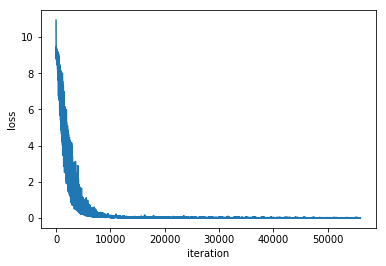

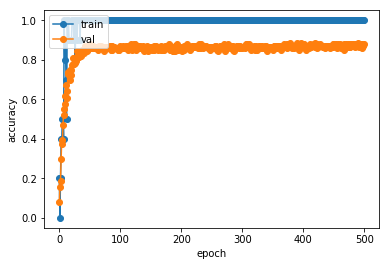

In [18]:
import matplotlib.pyplot as plt

plt.plot(train_loss_history, '-')
#plt.plot(val_loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()

plt.plot(train_acc_history, '-o')
plt.plot(val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [19]:
print(iter_per_epoch)

112


In [20]:
inputs

Variable containing:
( 0 , 0 ,.,.) = 
  0.0000  0.0000  0.3196  ...   0.1686  0.1647  0.1637
  0.0000  0.0000  0.3206  ...   0.1716  0.1647  0.1647
  0.0000  0.0000  0.3225  ...   0.1725  0.1647  0.1647
           ...             ⋱             ...          
  0.0000  0.0000  0.0000  ...   0.2608  0.2588  0.2559
  0.0000  0.0000  0.0000  ...   0.0000  0.2588  0.2510
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
      ⋮  

( 1 , 0 ,.,.) = 
  0.0000  0.0000  0.3176  ...   0.0000  0.1020  0.0000
  0.0000  0.0000  0.3196  ...   0.0510  0.1020  0.0961
  0.0000  0.0000  0.3216  ...   0.1020  0.1020  0.0980
           ...             ⋱             ...          
  0.0000  0.0000  0.0000  ...   0.1686  0.1686  0.1647
  0.0000  0.0000  0.0000  ...   0.1696  0.1647  0.1637
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
      ⋮  

( 2 , 0 ,.,.) = 
  0.0000  0.0000  0.3176  ...   0.0000  0.0000  0.0000
  0.0000  0.0000  0.3216  ...   0.0980  0.0951  0.0941
  0.0000  0.0000  0.3206  